<h1> Creating the Best Fantasy Basketball Lineup </h1>

<h2> Introduction </h2>

Fantasy basketball, and fantasy sports in general, is an extremely popular game where participants compete against each other by virtually selecting players from real upcoming games to create a lineup. Typically, the goal is to assemble the best all-star team, meaning participants are allowed to select players from different professional teams that compete in the same league to play in each coach's virtual team.

A basketball team typically consists of five players: a point guard (PG), a shooting guard (SG), a small forward (SF), a power forward (PF), and a center (C). Each player, assigned to these positions, can have different characteristics and objectives in the basketball game. A shooting guard might specialize in scoring, while a point guard's objective might be to run the game-plan and distribute the ball efficiently. To help compare players across different positions we need to find a common metric to assess each player's performance -- and we'll use fantasy points to do this.

In a follow-on example we will extend the optimization model to reflect actual fantasy basketball competitions found on major sites.

<h2> Objective and Prerequisites </h2>

In this example, we'll take on the role of a basketball coach and learn how to find the optimal lineup of National Basketball Association (NBA) players in the context of fantasy basketball. The goal is to select the five players who are going to perform the best in the NBA games played on December 25, 2017, by simultaneously satisfying player and position eligibility and budget constraints.

We aim to demonstrate that predictive modeling and mathematical optimization are closely connected, and how they can be integrated to derive optimal decisions. Simply starting from a dataset, we will apply regression modeling techniques to make predictions about the performance of basketball players. But when taking into account the problem constraints, directly utilizing these forecasts to make player selections isn't straightforward. This is where mathematical optimization and the Gurobi Optimizer thrive to prove what the best viable lineup is, by formulating and solving a mixed-integer programming (MIP) problem that will maximize the lineup's **total fantasy points**.

This example is for beginners in mathematical optimization who may have some experience in data handling and predictive modeling and experience using Python.

The presented problem requires the installation of the following Python packages:

- **pandas** for data analysis and manipulation
- **numpy** for calculations
- **matplotlib** and **seaborn** for plotting and visualizing information
- **scikit-learn** for accessing data science predictive tools
- **gurobipy** for utilizing Gurobi to formulate and solve the optimization problem

<h2> Problem Statement and Solution Approach</h2>

Given the regular season historical performances (box scores) of NBA players for the seasons 2016-2017 and 2017-2018, the eligible positions for each of the players, and a budget restriction on how much total salary we are allowed to spend for our team, select the five NBA players who are going to have the best performance on the NBA games played on Christmas day of the 2017-2018 season.

Among the eligible players that are going to play that day, we need to select a point guard, a shooting guard, a shooting forward, a power forward, and a center.

The solution to the problem consists of two components: 1) **fantasy points forecast** and 2) **lineup optimization**.

<h3> Fantasy Points Forecast </h3>

Let's start by loading the necessary libraries to solve our problem.

In [1]:
%pip install gurobipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 29.4 MB/s eta 0:00:00


In [2]:
import pandas as pd                                       #importing pandas
import numpy as np                                        #importing numpy
import matplotlib.pyplot as plt                           #importing matplotlib
import seaborn as sns                                     #importing seaborn
from sklearn.model_selection import train_test_split      #importing scikit-learn's function for data splitting
from sklearn.linear_model import LinearRegression         #importing scikit-learn's linear regressor function
from sklearn.metrics import mean_squared_error            #importing scikit-learn's root mean squared error function for model evaluation
from sklearn.model_selection import cross_validate        #improting scikit-learn's cross validation function
import gurobipy as gp                                     #importing Gurobi


We are going to use two publicly available datasets from [Kaggle](https://www.kaggle.com). The [first dataset](https://www.kaggle.com/pablote/nba-enhanced-stats) contains the historical information of the players' and teams' performances and will be for training and testing our predictive model. The [second dataset](https://www.kaggle.com/alandu20/daily-fantasy-basketball-draftkings) includes the salaries of players, as well as their eligible position. Note that *salaries* here are determined by sites that host the fantasy sports contests and have nothing to do with what the players are actually paid.

We have slightly preprocessed the two datasets to have consistency in the players' names as well as including solely the columns that we would need for the purposes of this project. Also, we utilize observations where athletes have played for at least 3 minutes in a basketball game. Both of the updated versions of the datasets are available in our **repository**.

We begin by reading the boxscores dataset, which includes the regular season performances for all players from season 2016-2017 up to the games played on December 25th, 2017. For games before that date, we calculated each player's total fantasy points using box score values as follows:

<font size="3">$FP = Points + 1.5 \times Assists - 0.5 \times Turnovers + Steals + 2 \times Blocks + 1.25 \times Rebounds + 0.5 \times ThreePointer$</font>

This value is already calculated in the **boxscores_dataset.csv** file.

In [3]:
# running locally
boxscores = pd.read_csv('boxscores_dataset.csv')     #load boxscores dataset
boxscores = boxscores[(boxscores.playMin>=3) | (boxscores.playMin.isnull())]

In general, fantasy points are connected with features related to the utilization and efficiency of each player and we can examine some of these relationships through visualization. Below are a few scatterplots, but feel free to add more visuals to get a deeper understanding of what's happening in the data.

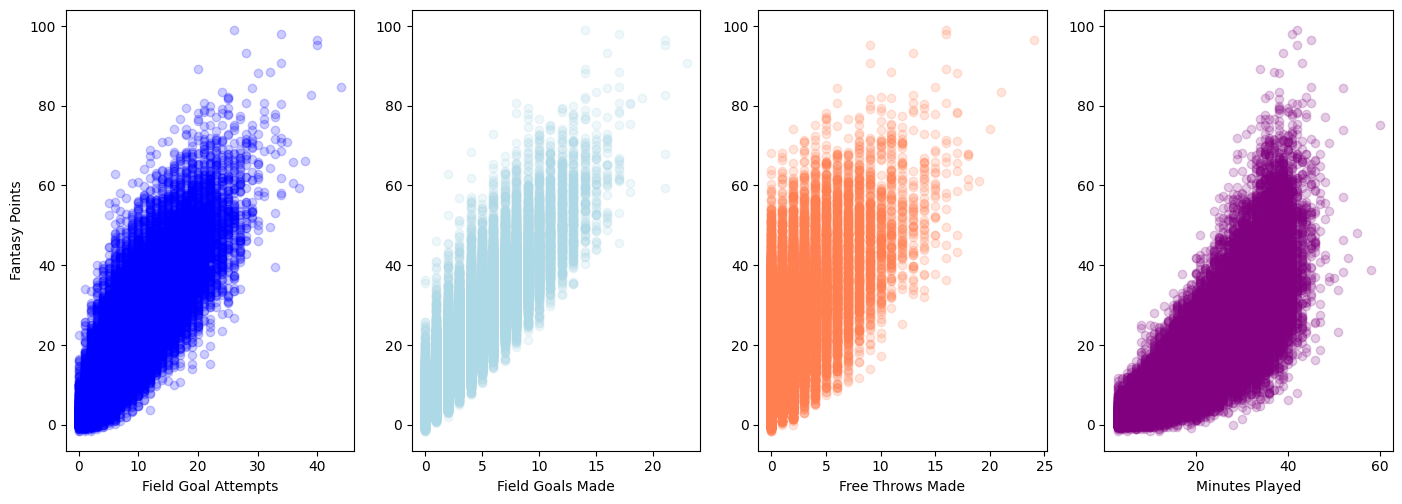

In [4]:
fig, (FGA, FGM, FTM, Min) = plt.subplots(1, 4, figsize=(14,5))
fig.tight_layout()

FGA.scatter(boxscores['playFGA'], boxscores['FantasyPoints'], c='blue', alpha = .2)
FGM.scatter(boxscores['playFGM'], boxscores['FantasyPoints'], c='lightblue', alpha = .2)
FTM.scatter(boxscores['playFTM'], boxscores['FantasyPoints'], c='coral', alpha = .2)
Min.scatter(boxscores['playMin'], boxscores['FantasyPoints'], c='purple', alpha = .2)

FGA.set_xlabel('Field Goal Attempts')
FGM.set_xlabel('Field Goals Made')
FTM.set_xlabel('Free Throws Made')
Min.set_xlabel('Minutes Played')

FGA.set_ylabel('Fantasy Points');

A distribution plot of the true fantasy points of the players for the previous games is shown below:

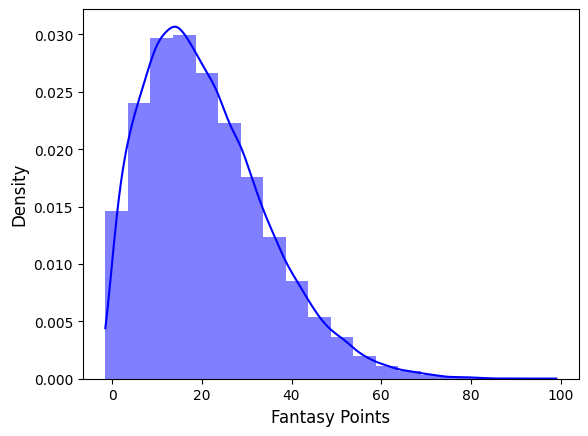

In [5]:
hplot = sns.histplot(boxscores['FantasyPoints'], color="blue", label="Fantasy Points", kde=True, stat="density", linewidth=0, bins=20)
hplot.set_xlabel("Fantasy Points", fontsize = 12)
hplot.set_ylabel("Density", fontsize = 12)
sns.set(rc={"figure.figsize":(14, 5)})

When building our predictive model, fantasy points scored in a game is a good target (or independent) variable. But what about the model's features?

One approach is to use boxscore data for a player's previous several games to find the average of key stats over that span. We will begin with the average of the three previous games for: points, assists, turnovers, steals, blocks, total rebounds, field goal attempts, free throw attempts, 2-pointer \%, 3-pointer \%, free throw \%, minutes played, days-off and the true fantasy points.

For example, this calculation for the assists at the $k^{th}$ game is:

<font size="4">$Average \hspace{0.1cm} Assists_k = \frac{Assists_{k-1}+Assists_{k-2}+Assists_{k-3}}{3}$</font>

In [6]:
horizon=3

for column_name in ['playPTS','playAST','playTO','playSTL','playBLK','playTRB','playFGA','playFTA','play2P%','play3P%','playFT%','playMin','teamDayOff','FantasyPoints']:
    boxscores['moving' + column_name] = boxscores.groupby(['playDispNm'])[column_name].transform(lambda x: x.rolling(horizon, 1).mean().shift(1))                           #lagged moving average of numeric features

This gives us a set of features to start with, though we still would want to perform feature selection for our predictive model. Changing the number of lag games may improve your predictive model -- so give it a try!

Because we are using a lagged average, there is not any historical information for the first game played for each player, so we drop these observations.

In [7]:
boxscores.dropna(subset = ["movingplayPTS"], inplace=True)               #drop the first observation for each player

To start with feature selection, we can look at the correlation between our newly derived variables, which is shown below:

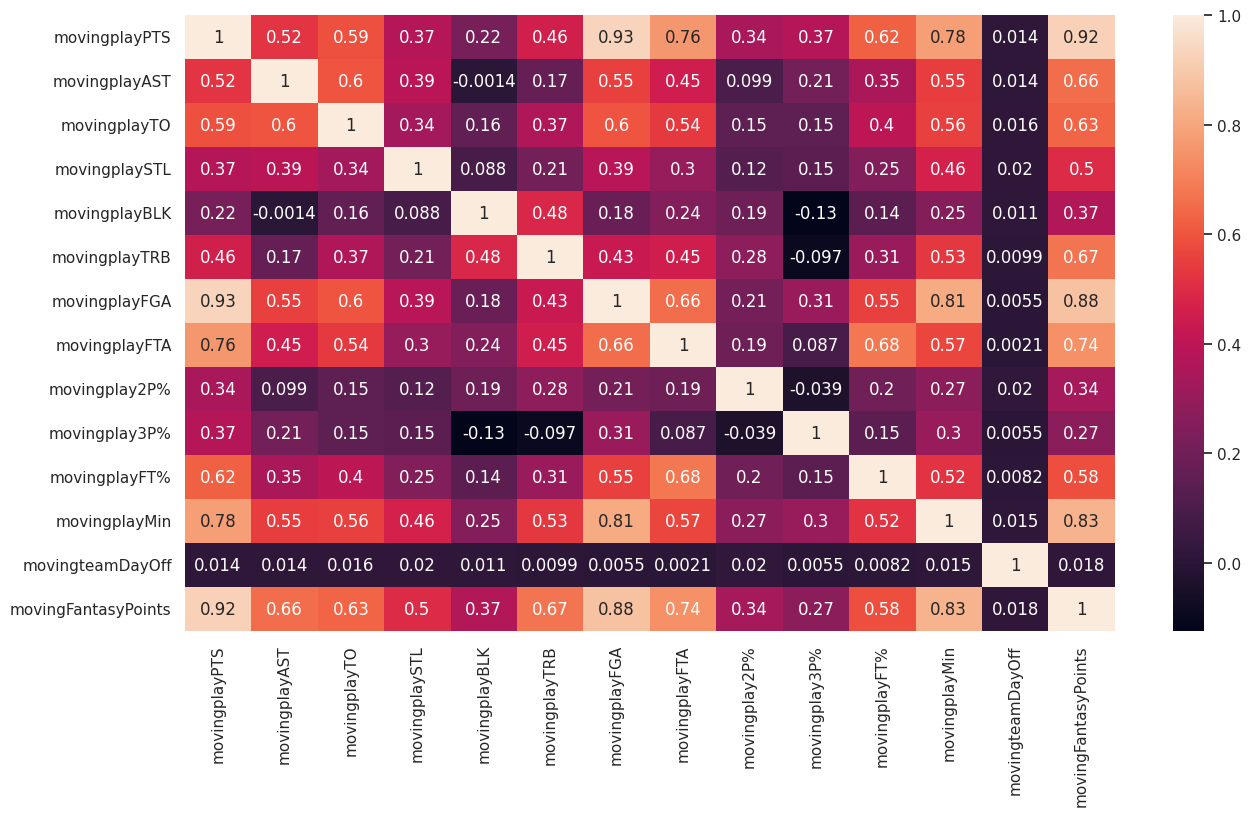

In [8]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(boxscores[['movingplayPTS', 'movingplayAST','movingplayTO','movingplaySTL','movingplayBLK','movingplayTRB','movingplayFGA','movingplayFTA','movingplay2P%','movingplay3P%','movingplayFT%','movingplayMin','movingteamDayOff','movingFantasyPoints']].corr(),annot=True)
plt.show()

We observe that some of the features are highly correlated. For example, the average of free throw attempts with the points average.

We are also investigating the utilization of two categorical variables. Specifically, if the current game is home or away and if the player will start or come from the bench. We transform the categorical variables to 0-1 variables.

In [9]:
boxscores['dummyTeamLoc'] = pd.get_dummies(data=boxscores['teamLoc'],drop_first=True)    #1 if the game is a home game, 0 if it is an away game
boxscores['dummyplayStat'] = pd.get_dummies(data=boxscores['playStat'],drop_first=True)  #1 if the player starts, 0 if the player comes from the bench

Now that the dataset has been updated, we move into forecasting the fantasy points for the players who are going to play on December 25, 2017.

In [10]:
forecasting_data = boxscores[boxscores.gmDate != '2017-12-25']
#for model training, we exclude observation on December 25, 2017
print(forecasting_data.shape)

(35019, 69)


We split the data set using 80\% of the data for training and 20\% for testing. For forecasting we try three models: linear regression, a neural network and a gradient boosting regressor. In addition to the heat map, we based out statistical significance tests and looked into multicollinearity using variance inflation factors (VIF). Cross-validation is also used to identify potential overfitting.

The features that will be used for our predictive models are the average of the player's: assists, turnovers, steals, blocks, total rebounds, free throw attempts, free throw %, as well as whether the player will start or will come from the bench.

In [11]:
X = forecasting_data[['movingplayAST','movingplayTO','movingplaySTL','movingplayBLK','movingplayTRB','movingplayFTA','movingplayFT%','dummyplayStat']]  #select the features that will be used for model training
y = forecasting_data['FantasyPoints']  #target set
print(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)      #dataset splitting

linear_regressor = LinearRegression()                                                         #load linear regressor
linear_regressor.fit(X_train, y_train)                                                        #train the linear regression model
linear_regression_validation = cross_validate(linear_regressor, X_train, y_train, cv=5, return_train_score=True, return_estimator=True)

2         6.00
3        10.75
4         8.50
5         9.00
6         3.00
         ...  
36752    21.25
36753    22.50
36756     4.50
36758     2.75
36760     0.00
Name: FantasyPoints, Length: 35019, dtype: float64


In [12]:
linear_regression_validation['test_score']                            #print CV test score across each fold

array([0.50930902, 0.50013374, 0.48346951, 0.49492734, 0.5043561 ])

We observe that the model performs consistently across each of the folds. Now, to evaluate the performance of the models we calculate their mean squared error (MSE) values.

In [13]:
linear_regression_predictions = linear_regressor.predict(X_test)                              #make predictions based on the test set for the linear regression model
linear_regression_mse = mean_squared_error(y_test, linear_regression_predictions)             #calculate the MSE for the linear regression model
                                           #calculate the MSE for the gradient boosting model
results = {'Linear Regression':[linear_regression_mse]}
modeling_results = pd.DataFrame(data=results,index=['MSE'])

modeling_results

,Linear Regression
MSE,91.077312


Each of the model types perform similarly well as shown from their mean squared error values. Also, plots of the predicted value error with respect to the predicted fantasy points are shown in the following figures:

Text(19.5, 0.5, 'Linear Regression Residual')

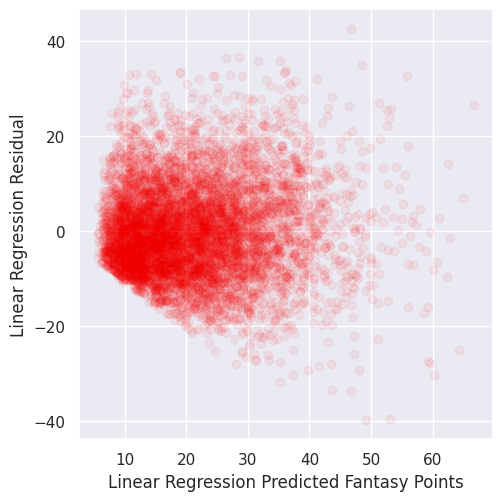

In [14]:
fig, (LR) = plt.subplots(1, 1,figsize=(5,5));
fig.tight_layout()

LR.scatter(x = linear_regression_predictions, y = y_test - linear_regression_predictions,color='red',alpha=0.06)
LR.set_xlabel('Linear Regression Predicted Fantasy Points')
LR.set_ylabel('Linear Regression Residual')

As we see from the above plots and the test scores, our models can only partially explain the variance of the fantasy points. That is to be expected since there are so many factors that affect the performance of the players. By a slight margin the gradient boosting regressor had the lowest MSE, so we'll refit that model to the complete data set and use that to predict fantasy points.

After that, we'll append the predicted fantasy points to the salary data to set up the optimization part of the solution.

In [15]:
LR_final = linear_regressor
LR_final.fit(X, y)

optimization_dataset = boxscores
optimization_dataset['PredictedFantasyPoints'] = LR_final.predict(boxscores[['movingplayAST','movingplayTO','movingplaySTL','movingplayBLK','movingplayTRB','movingplayFTA','movingplayFT%','dummyplayStat']])

print(optimization_dataset)

       Unnamed: 0      gmDate gmTime  seasTyp  playLNm    playFNm teamAbbr  \
2            1382  2016-11-02  10:30  Regular  Abrines  Alejandro      OKC   
3            1492  2016-11-03  10:30  Regular  Abrines  Alejandro      OKC   
4            1724  2016-11-05   6:00  Regular  Abrines  Alejandro      OKC   
5            2130  2016-11-07   8:00  Regular  Abrines  Alejandro      OKC   
6            2447  2016-11-09   8:00  Regular  Abrines  Alejandro      OKC   
...           ...         ...    ...      ...      ...        ...      ...   
36752       23335  2017-03-26   9:30  Regular    Zubac      Ivica      LAL   
36753       23622  2017-03-28  10:30  Regular    Zubac      Ivica      LAL   
36756       29682  2017-11-09   7:00  Regular    Zubac      Ivica      LAL   
36758       31582  2017-11-21  10:30  Regular    Zubac      Ivica      LAL   
36760       33441  2017-12-03   9:30  Regular    Zubac      Ivica      LAL   

      teamConf    teamDiv teamLoc  ... movingplayFTA  movingpla

In [17]:
player_results = pd.read_csv('target_games.csv')
player_list = list(player_results['Player'].unique())
print(player_list)
print(len(player_results))
col = pd.DataFrame()
print(col)

['James Harden', 'LeBron James', 'Russell Westbrook', 'Kevin Durant', 'Joel Embiid', 'Ben Simmons', 'Karl-Anthony Towns', 'Kristaps Porzingis', 'Jimmy Butler', 'Kyrie Irving', 'John Wall', 'Kevin Love', 'Kyle Kuzma', 'Draymond Green', 'Bradley Beal', 'Paul George', 'Al Horford', 'Clint Capela', 'Klay Thompson', 'Dario Saric', 'Robert Covington', 'Enes Kanter', 'Jeff Teague', 'Taj Gibson', 'Andrew Wiggins', 'Carmelo Anthony', 'Eric Gordon', 'Steven Adams', 'Jayson Tatum', 'Otto Porter', 'Jaylen Brown', 'Kentavious Caldwell-Pope', 'Michael Beasley', 'Dwyane Wade', 'J.J. Redick', 'Julius Randle', 'Trevor Ariza', 'Marcin Gortat', 'Jordan Bell', 'Marcus Smart', 'Courtney Lee', 'P.J. Tucker', 'Jordan Clarkson', 'Jarrett Jack', 'Marcus Morris', 'Ryan Anderson', 'Kelly Oubre Jr.', 'Mike Scott', 'Larry Nance Jr.', 'Markieff Morris', 'Omri Casspi', 'Trevor Booker', 'Terry Rozier', 'Jeff Green', 'J.R. Smith', 'T.J. McConnell', "Kyle O'Quinn", 'Frank Ntilikina', 'Andre Iguodala', 'Jamal Crawford',

In [18]:
for player in player_list:
    player_flag = player
    optimization_data_per_player = optimization_dataset.loc[(optimization_dataset['playDispNm']==player)&(optimization_dataset['gmDate']=='2017-12-25')]
    col = pd.concat([col, optimization_data_per_player])

print(len(col))

96


In [19]:
print(len(col['PredictedFantasyPoints'].values))
col['PredictedFantasyPoints'].values

96


array([57.50292877, 48.62577669, 44.47770707, 40.42310464, 47.90664522,
       39.71755432, 34.08199815, 26.97064828, 38.90996539, 31.39110555,
       36.64424515, 27.67551969, 37.66886023, 40.4739013 , 25.9524105 ,
       36.09298826, 28.44873602, 33.95355516, 28.5072764 , 38.09279546,
       30.13478234, 26.97791857, 32.86524139, 20.66529554, 21.53979805,
       25.36698876, 21.88233062, 30.00283741, 26.39283226, 18.52281139,
       25.60093786, 26.29937708, 24.74599146, 21.59656179, 23.85869365,
       21.06577181, 28.04089906, 24.64469386, 32.39928107, 20.03853436,
       26.08469366, 17.4775796 , 20.00607639, 27.4023905 , 17.05883608,
       24.40206708, 16.80225945, 13.23678376, 16.95695753, 24.93591739,
       16.42362993, 17.2277598 , 13.51851372, 19.80727231, 20.08998261,
       14.56057303, 17.333847  , 15.40168508, 18.48430395, 18.0069475 ,
       13.08400197, 15.43962466, 21.82423021, 14.9335112 , 12.25406684,
       13.0226083 , 22.90860406, 23.66790091, 19.75114218, 17.87

We also calculate another column which is the predicted fantasy points divided by the salary of each player.

In [20]:
player_results['PredictedFantasyPoints'] = col['PredictedFantasyPoints'].values

In [21]:
pd.set_option('display.expand_frame_repr', False)
player_results['Points/Salary Ratio'] = 1000*player_results['PredictedFantasyPoints']/player_results['Salary']    #we multiple the fantasy vs salary ratio by 1000 for better visualization
player_results.sort_values(by='PredictedFantasyPoints',ascending=False).head(5)

,Player,Pos,Team,Opp,Salary,PredictedFantasyPoints,Points/Salary Ratio
0,James Harden,PG,HOU,@ OKC,11100,57.502929,5.180444
1,LeBron James,SF,CLE,@ GSW,11000,48.625777,4.420525
4,Joel Embiid,C,PHI,@ NYK,9500,47.906645,5.042805
2,Russell Westbrook,PG,OKC,vs HOU,10900,44.477707,4.080524
13,Draymond Green,PF,GSW,vs CLE,7200,40.473901,5.621375


So how many potential lineups are there? A lot.

$24PG \times 22SF \times 22SG \times 19PF \times 9C = 1,986,336$ combinations

Using brute force to calculate the total fantasy points for each lineup would take a very, very long time. We also need to consider the salary constraint (e.g. $30,000). A greedy approach (i.e. always taking the best player available) would select the first three players that have the highest fantasy points (Embiid, James, and Harden), but then realize that the salary cap will be violated. Using the points to salary ratio can also lead to the same issue.   

This is where optimization becomes most advantageous, due to its ability to efficiently explore the space of options in a very efficient manner and provably showing you have an optimal solution.

<h3> Optimal Lineup Selection </h3>

Now that we have predictions for the players in our slate of NBA games we can work on determining our optimal lineup.

First, we'll make some definitions as these are helpful for us to set up our optimization model. For starters, the subscript $i$ will be used to denote individual players across the set of all players we can choose from.

**Input Parameters**

$p_{i}$: the predicted fantasy points of player $i$

$s_{i}$: the salary of player $i$

$S$: our total available salary

Here is the code to set up the indices and parameters:

In [22]:
indices = player_results.Player
points = dict(zip(indices, player_results.PredictedFantasyPoints))
salaries = dict(zip(indices, player_results.Salary))
S = 30000

m = gp.Model();        # this defines the model that we'll add to as we finish the formulation

Restricted license - for non-production use only - expires 2025-11-24


**Decision Variables**

The goal of this problem is to determine whether each player is in our final lineup. This an example of when *binary variables* are used in optimization, to represent a **yes** or **no** decision we want to make. This is modeled as $y_{i} = 1$: if player $i$ is selected; and $y_{i} = 0$ otherwise.

Here is where we add a set of decision variables to our model in gurobipy:

In [23]:
y = m.addVars(player_results.Player, vtype=gp.GRB.BINARY, name="y")

**Objective Function**

The objective of our problem is to maximize the total fantasy points of our lineup. Since we are using binary variables, if a player is selected ($y_{i} = 1$), then their predicted points will contribute to our lineup using $p_{i} \cdot y_{i}$. If $y_{i} = 0$ then $p_{i} \cdot y_{i} = 0$ as well. Summing across all players will give us the function to maximize, written as:

\begin{align}
 Max \hspace{0.2cm} Z = \sum p_{i} \cdot y_{i}
\end{align}

Below is one way to write a summation using the quicksum function in gurobypi (you can get other ways to work) which we add to our model as the objective:

In [24]:
# since we are maximizing points the last argument here is GRB.MAXIMIZE
m.setObjective(gp.quicksum(points[i]*y[i] for i in indices), gp.GRB.MAXIMIZE)

**Constraints**

We need to guarantee that each position has exactly one player assigned. Since our decision variables are each 0 or 1, we can model this by adding a constraint for each position summing across the eligible players (and decision variables) requiring that sum to be equal to 1:

\begin{align}
\sum_{i \space eligible} y_{i} = 1
\end{align}

Looping over the positions will add a constraint for each while the condition in the quicksum function will tell the model to only sum over players if they are eligible for that position:

In [25]:
player_position_map = list(zip(player_results.Player, player_results.Pos))
for j in player_results.Pos:
    m.addConstr(gp.quicksum([y[i] for i, pos in player_position_map if pos==j])==1)

Additionally, we need to ensure that the total salary must not exceed a certain threshold:

\begin{align}
\sum s_{i} \cdot y_{i} \leq S
\end{align}

In [26]:
m.addConstr(gp.quicksum(salaries[i]*y[i] for i in indices) <= S, name="salary");
#the budget for the selected team must not exceed 30,000

Now we've added all of the required parts to our optimization model and we are ready to solve.

In [27]:
m.optimize()  #we optimize our model

Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 97 rows, 96 columns and 2082 nonzeros
Model fingerprint: 0xf2596738
Variable types: 0 continuous, 96 integer (96 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [7e+00, 6e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+04]
Found heuristic solution: objective 136.3893261
Presolve removed 91 rows and 55 columns
Presolve time: 0.00s
Presolved: 6 rows, 41 columns, 82 nonzeros
Found heuristic solution: objective 160.6497955
Variable types: 0 continuous, 41 integer (41 binary)

Root relaxation: objective 1.697760e+02, 9 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent   

Much of the output above can be ignored for now, but will provide valuable information as you create larger and more complicated models. Let's focus on the last two lines which says an optimal solution was found and its objective value.

We need to extract the solution from the model to find which players are selected. Using getVars() gets the value of each decision variable, so we loop through the decision variables checking if its value (using .x) is greater than 0. While in the loop we record info about each player selected in a data frame.

In [28]:
results = pd.DataFrame()

for v in m.getVars():
    if v.x > 1e-6:
        results = pd.concat([results,player_results.iloc[v.index][['Player','Pos','PredictedFantasyPoints','Salary']]])
        print(v.varName, v.x)

print('Total fantasy score: ', m.objVal)

y[Joel Embiid] 1.0
y[Paul George] 1.0
y[Trevor Ariza] 1.0
y[Jordan Bell] 1.0
y[Josh Hart] 1.0
Total fantasy score:  168.10771451665119


In [29]:
print(results)

                                   0
Player                   Joel Embiid
Pos                                C
PredictedFantasyPoints     47.906645
Salary                          9500
Player                   Paul George
Pos                               SF
PredictedFantasyPoints     36.092988
Salary                          6800
Player                  Trevor Ariza
Pos                               SG
PredictedFantasyPoints     28.040899
Salary                          5000
Player                   Jordan Bell
Pos                               PF
PredictedFantasyPoints     32.399281
Salary                          4900
Player                     Josh Hart
Pos                               PG
PredictedFantasyPoints     23.667901
Salary                          3700


Because the games were played, we also look up the true fantasy points of the players selected for the games on December 25, 2017, and we add that to our results dataframe.

Let's quickly revisit the idea of putting together a lineup in a *greedy* fashion, meaning we start with the *best available* choice and repeat. Notice that players we predicted to have very high scoring games, such as James Harden or Lebron James, didn't make the optimal roster, so going after just the high scorers can be suboptimal.

If you were to re-sort the salary table by the ratio of predicted points to salary, we'd see PF Jordan Bell and PG Josh Hart atop the list. But neither of those players are in the optimal lineup as well, so even using that metric can lead to a suboptimal solution.

This shows the power of mathematical optimization. Our simple model was able to consider over 2 million possibilities and arrive at an optimal solution that would have been overlooked if we were to apply some intuitive decision rules when creating a lineup.

In [ ]:
m.dispose()
gp.disposeDefaultEnv()

Freeing default Gurobi environment


<h2> Conclusion </h2>

In this example you learned how to optimize your basketball lineup in the context of fantasy sports. Starting with box score data, we constructed models that predict the future fantasy points of NBA athletes and then developed an optimization formulation to calculate the best lineup subject to budget and position eligibility constraints.

Through this example, our aim was to clearly present some of the connections between data science and mathematical optimization by starting with data and ending with a decision. We also saw how easy it is to make suboptimal decisions even when applying sensible rules.

We also have a more advanced fantasy basketball problem that uses the same predictive element but expands the optimization component to reflect real fantasy basketball contests from popular sites.